# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lib.utils as utils
import yaml

# Reading In Model Metrics

### This dataframe contains the model performance metrics from the train I performed. The columns include the validation MAE, test MAE, and test RMSE of the model run of their respective datasets. 

In [2]:
df = pd.read_csv("metric_seed1.csv")
df

,val_mae,test_mae,test_rmse
0,59742.062,53139.8050,349243.750
1,19856.299,17575.5570,125415.270
2,15039.944,12867.9600,91571.250
3,13273.958,9995.8090,62587.207
4,12781.422,9133.1780,61111.008
5,11537.903,8744.8770,56918.950
6,11891.605,8856.7160,58590.016
7,9494.588,6640.4907,46418.970
8,9342.224,6435.0825,40443.973
9,9037.473,6204.2340,41694.950


# Final Metrics (Population / 1,000)

### These are the final metrics of the model run after fully training. In accordace with the paper, I reported the metrics with respect to population divided by 1,000.

In [3]:
df.iloc[-1, :] / 1000

val_mae       7.600173
test_mae      5.145163
test_rmse    38.471164
Name: 11, dtype: float64

# Obtain Percentages of Data Used Per Iteration During Training

### This code reverse engineers the model training to calculate the percent of data used during each iteration and the subsequent test MAE of that iteration. The step by step write up is included below.

## Step 1: Load the configurations file.

##### This allows us to extract the data from the correct places and track the necessary variables for this process to work

In [4]:
with open("data/model/dcrnn_cov.yaml") as f:
    supervisor_config = yaml.safe_load(f)

## Step 2: Load the Initial Dataset

##### This loads in the initial dataset. The shape for any model run of the initial dataset is the same and therefore, for the sake of the task we performed, is consistent.

In [5]:
data, search_data_x, search_data_y = utils.load_dataset(**supervisor_config.get('data'))

In [6]:
f"Initial Training Data Size: {data["x_train"].shape[0]}"

'Initial Training Data Size: 1728'

## Step 3: Calculate Data Percents' Denominator

##### For this step, I calculated the denominator for the 'percent of data used' calculation. The steps are below
    > Load the curr dataset
    > Take the "x" parameter
    > Extract the rows
    > Add it to the total number of rows

In [7]:
types = ["train", "val", "test"]
total_data_len = 0
for item in types:
    curr_set = np.load(f"data/data/{item}.npz", allow_pickle=True)
    curr_set_x = curr_set["x"]
    curr_set_x_rows = curr_set_x.shape[0]
    total_data_len += curr_set_x_rows

total_data_len

20898

## Step 4: Calculate the percent of data that was used to train the model.

##### For this step, we performed the following steps:
    > Create the base loop. We used 12 as that was the number of iterations the model trained on (12 queried data points)
    > Load the corresponding reward and index lists of that iteration
    > Take the max reward from the reward list
        > This mimics what the model does to select which index it is going to use to select data for the model
    > Query the selected data
    > Preprocess the selected data and previous data
    > Pass the preprocessed data into the 'generate_new_trainset()' function to generate the new training dataset
    > Take the shape of this new training dataset, divide its rows by the total rows we calculated above, and append that percent to the 'all_percents' list

In [ ]:
# Base Loop To Get Percent Per Iteration
all_percents = []
for i in range(1, 13):
    # Reward and Index List at Iteration "i"
    reward_list = np.load(f"seed1/reward_list/itr{i}.npy")
    index_list = np.load(f"seed1/index_list/itr{i}.npy")

    # The Selected Data For the Iteration
    selected_ind = np.argmax(np.array(reward_list))
    selected_data_x = [search_data_x[i] for i in index_list[selected_ind]]
    selected_data_y = [search_data_y[i] for i in index_list[selected_ind]]

    # Preprocessing Before Creating New Training Dataset
    selected_data = {}
    selected_data['x'] = selected_data_x
    selected_data['y'] = selected_data_y
    search_config = supervisor_config.get('data').copy()
    search_config['selected_data'] = selected_data
    search_config['previous_data'] = data

    # Create New Training Dataset
    data = utils.generate_new_trainset(**search_config)

    # Get the Dataset Shape and Percent of Data Used To Train
    print(f"Train Iteration {i} Train Data Percent: {data["x_train"].shape[0] / total_data_len}")
    all_percents.append(data["x_train"].shape[0] / total_data_len)

Train Iteration 1 Train Data Size: 2202
Train Iteration 2 Train Data Size: 2571
Train Iteration 3 Train Data Size: 3009
Train Iteration 4 Train Data Size: 3366
Train Iteration 5 Train Data Size: 3720
Train Iteration 6 Train Data Size: 4155
Train Iteration 7 Train Data Size: 4557
Train Iteration 8 Train Data Size: 4953
Train Iteration 9 Train Data Size: 5337
Train Iteration 10 Train Data Size: 5742
Train Iteration 11 Train Data Size: 6150
Train Iteration 12 Train Data Size: 6507


In [9]:
all_percents

[0.10536893482629917,
 0.1230261269020959,
 0.1439850703416595,
 0.16106804478897502,
 0.17800746482917026,
 0.19882285386161355,
 0.21805914441573357,
 0.23700832615561299,
 0.2553832902670112,
 0.2747631352282515,
 0.29428653459661214,
 0.31136950904392763]

##### In this portion, we notice that the percents do not line up with the percents of the paper. Due to this, a little experimentation was done to try and reverse engineer these percents but to no avail. There will be further work on this aspect of the code

## Step 5: Create Plot of Our Model Run vs. Paper's Metrics

##### Below are the steps
    > Define the paper's metrics and errors to create 'bands' that make comparing the model performance easier from a visual perspective
    > Create our model plot from the dataframe define above

In [10]:
paper_avgs = np.array([14.447, 11.704, 7.593, 6.539, 6.008])

In [11]:
paper_errors = np.array([1.087, 0.216, 0.822, 0.618, 1.079])

In [12]:
lower_paper_bound = paper_avgs - paper_errors
upper_paper_bound = paper_avgs + paper_errors

In [13]:
paper_percents = [0.111, 0.137, 0.213, 0.289, 0.365]

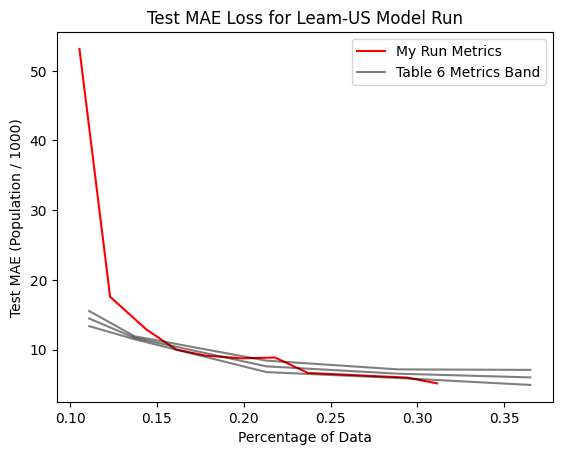

In [19]:
plt.ylabel("Test MAE (Population / 1000)")
plt.xlabel("Percentage of Data")
plt.title("Test MAE Loss for Leam-US Model Run")
plt.plot(all_percents, df["test_mae"]/1000, color="red", label="My Run Metrics")

plt.plot(paper_percents, paper_avgs, color="black", label="Table 6 Metrics Band", alpha=0.5)
plt.plot(paper_percents, lower_paper_bound, color="black", alpha=0.5)
plt.plot(paper_percents, upper_paper_bound, color="black", alpha=0.5)
plt.legend()

##### For the sake of comparing percentages and compiling them into a single location, I added all necessary statistics to the dataframe declared above. 

In [20]:
df["percent_data"] = all_percents

In [21]:
df["pop_div_hundred_test_mae"] = df["test_mae"] / 1000

In [22]:
df

,val_mae,test_mae,test_rmse,percent_data,pop_div_hundred_test_mae
0,59742.062,53139.8050,349243.750,0.105369,53.139805
1,19856.299,17575.5570,125415.270,0.123026,17.575557
2,15039.944,12867.9600,91571.250,0.143985,12.867960
3,13273.958,9995.8090,62587.207,0.161068,9.995809
4,12781.422,9133.1780,61111.008,0.178007,9.133178
5,11537.903,8744.8770,56918.950,0.198823,8.744877
6,11891.605,8856.7160,58590.016,0.218059,8.856716
7,9494.588,6640.4907,46418.970,0.237008,6.640491
8,9342.224,6435.0825,40443.973,0.255383,6.435083
9,9037.473,6204.2340,41694.950,0.274763,6.204234


## Conclusion

##### For the plotting done, we can see that there is a significant discrepancy in the intial training iteration performance in comparison to the paper's performance. Noticing this discrepancy, we decided to debug our model and confirm why this potentially happened. Some of the debugging is done in the file "events.ipynb". 

##### We also notice a discrepancy in the percentages mentioned in the paper and the percents found in the calculations above. Further work will be done in regards to this. 